# Overview

**GENERAL THOUGHTS:**
- ...


**DATA PREPROCESSING:**

Imbalanced data:
- over_sampling for imbalanced data
- cost-sensitive learning for imbalanced data

categorical data:
- Ordinal Data: The categories have an inherent order
- Nominal Data: The categories do not have an inherent order



**MULTI-CLASS CLASSIFIER:**
- Focus on "Native Multiclass Classifiers" as a starting point. Might try "Binary Transformation" or "Hierarchical Classification" later. https://www.projectpro.io/article/multi-class-classification-python-example/547
- Overview models to be considered:  
  - [X] Decision Trees

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import sklearn
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# import xgboost as xgb
# import lightgbm as lgbm

import optuna
# from optuna.samplers import TPESampler

import imblearn
from imblearn.over_sampling import RandomOverSampler

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform


In [4]:
SEED = 42

# Load data

In [5]:
df = pd.read_csv('../../data/output/df_ml.csv', sep='\t')

# Prep data for machine learning

## Clean data

In [6]:
df['material_number'] = df['material_number'].astype('object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82977 entries, 0 to 82976
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   material_number         82977 non-null  object 
 1   material_number_text    82977 non-null  object 
 2   brand                   82977 non-null  object 
 3   product_area            82977 non-null  object 
 4   core_segment            82977 non-null  object 
 5   component               82977 non-null  object 
 6   component_text          82977 non-null  object 
 7   manufactoring_location  82977 non-null  object 
 8   characteristic_value    82977 non-null  object 
 9   material_weight         75913 non-null  float64
 10  packaging_code          82977 non-null  object 
 11  packaging_category      82977 non-null  object 
dtypes: float64(1), object(11)
memory usage: 7.6+ MB


In [8]:
df_sub = df[[
    'material_number',
    'brand',
    'product_area',
    'core_segment',
    'component',
    'manufactoring_location',
    'characteristic_value',
    'material_weight', 
    'packaging_code',
    'packaging_category',
]]

## Split data into train/test

In [9]:
# Define features and target
X = df_sub.iloc[:, :-1]
y = df_sub.iloc[:, -1]  # the last column is the target

In [10]:
# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y,
    # random_state=SEED
)

# DecisionTree pipeline without oversampling

## DecisionTree (without HPO)

In [11]:
# DEFINE PIPELINE

# DEFINE PREPROCESSING PIPELINE
# define numerical feature processing
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
# print(f'There are {len(numerical_features)} numerical features:', '\n')
# print(numerical_features)
numeric_feature_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('log_transform', PowerTransformer()),
    # ('scale', MinMaxScaler())
])
# define categorical feature processing
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()
# print(f'There are {len(categorical_features)} categorical features:', '\n')
# print(categorical_features)
categorical_feature_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    # ('one_hot', OneHotEncoder(handle_unknown='ignore', max_categories=None, sparse=False))
])
# apply both pipeline on seperate columns using "ColumnTransformer"
preprocess_pipeline = ColumnTransformer(transformers=[
    ('number', numeric_feature_pipeline, numerical_features),
    ('category', categorical_feature_pipeline, categorical_features)
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

# DEFINE MODEL PIPELINE

label_ecoder = LabelEncoder()
y_train_transformed = label_ecoder.fit_transform(y_train)
# y_train_transformed = label_ecoder.fit_transform(y_train)

# class_weights
# class_weights = compute_sample_weight(
#     class_weight='balanced',
#     y=y_train_transformed
# )
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_transformed),
    y=y_train_transformed
)
class_weight_dict = dict(enumerate(class_weights))

# DEFINE MODEL PIPELINE
# model
dt_clf = DecisionTreeClassifier(
    # n_estimators=10,
    class_weight=class_weight_dict,
    # random_state=SEED
)

# Training
dt_clf.fit(X_train_transformed, y_train_transformed)

DecisionTreeClassifier(class_weight={0: 0.36161137440758295,
                                     1: 0.3272337383845604,
                                     2: 0.34813688212927757,
                                     3: 3.5598755832037323, 4: 1.308,
                                     5: 286.125, 6: 6.6347826086956525,
                                     7: 2.5043763676148796,
                                     8: 4.231053604436229, 9: 7.153125,
                                     10: 0.8227893601725378,
                                     11: 4.385057471264368, 12: 65.4,
                                     13: 0.7388637830858619,
                                     14: 9.69915254237288, 15: 19.075,
                                     16: 190.75, 17: 176.07692307692307,
                                     18: 1.5466216216216215,
                                     19: 5.899484536082475,
                                     20: 0.24481283422459893,
                                     21: 0.21127930588886837,
                                     22: 1.5029546946815495,
                                     23: 0.34488473708000605,
                                     24: 1.9186923721709974,
                                     25: 1.6756954612005857, 26: 57.225,
                                     27: 1.9090909090909092,
                                     28: 2.0220848056537104})

In [12]:
# preprocess & make predictions for test data
X_test_transformed = preprocess_pipeline.transform(X_test)
preds_y_test_dt = dt_clf.predict(X_test_transformed)

y_test_transformed = label_ecoder.transform(y_test)
preds_y_test_dt_inverse = label_ecoder.inverse_transform(preds_y_test_dt)

# score the pipeline
print("Train score (f1-score): ", dt_clf.score(X_train_transformed, y_train_transformed))
print("Test score (f1-score): ", dt_clf.score(X_test_transformed, y_test_transformed))
print(classification_report(y_test, preds_y_test_dt_inverse))

Train score (f1-score):  1.0
Test score (f1-score):  0.7425885755603759
                                precision    recall  f1-score   support

B01 - Blister and sealed blist       0.73      0.69      0.71      1582
   B02 Blister and Insert Card       0.68      0.68      0.68      1749
          C01 - Folding carton       0.71      0.65      0.68      1644
                 C02 Trap Card       0.73      0.75      0.74       161
         C03 Trap Folding Card       0.78      0.74      0.76       438
            C04 Book packaging       1.00      1.00      1.00         2
               C05 Tray Packer       0.17      0.12      0.14        86
                  C06 Skincard       0.87      0.82      0.84       229
C07 Cardb. Sleeve w - w/o Shr.       0.52      0.47      0.49       135
C08 - Cardboard hanger w/o bag       0.45      0.34      0.39        80
        C09 - Paperboard pouch       0.74      0.78      0.76       696
  C10 - Carton cover (Lid box)       0.55      0.45      0.49  

## DecisionTree HPO

### Performe HPO

In [13]:
class OptunaObjective(object):

    def __init__(self, scoring, X: np.array, y: np.array):
        self.scoring=scoring
        self.X=X
        self.y=y

    def __call__(self, trial: optuna.Trial) -> float:
        
        # joblib.dump(study, 'study.pkl')

        hp_rf_optuna = {
            'max_depth': trial.suggest_categorical('max_depth', [2, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 50, 60, 80, 100]), # Maximum number of levels in tree
            # 'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt','log2']), # Number of features to consider at every split
            # 'min_samples_split': trial.suggest_int('min_samples_split', 2, 14), # Minimum number of samples required to split a node
            # 'min_samples_leaf': trial.suggest_int('min_samples_split', 1, 8), # Minimum number of samples required at each leaf node
            'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']), # function to measure the quality of a split
        }

        # Generate train/val sets randomly for each trial to prevent overfitting
        X_train, X_val, y_train, y_val = train_test_split(
            self.X, self.y, test_size=0.2, stratify=self.y, random_state=None
        )

        # class_weights
        class_weights = compute_sample_weight(
            class_weight='balanced',
            y=y_train
        )
        class_weight_dict = dict(enumerate(class_weights))

        # model
        model = DecisionTreeClassifier(
            # n_estimators=1000,
            class_weight=class_weight_dict,
            **hp_rf_optuna,
            # random_state=SEED
        )

        # fit model
        # NOTE: cross_val within an HPO study is not suggested since it is an extra layer of computational complexity;
        #       often this is not needed OR it is anyways somehow covered by the optimization strategy, e.g. Bayesian
        model.fit(X_train, y_train)
        
        # eval performance
        preds_y_val = model.predict(X_val)
        clf_report = classification_report(y_val, preds_y_val, output_dict=True)

        return clf_report['macro avg']['f1-score']

In [14]:
# define hyper-parameter space, model + training, optimization metric via Objective
objective = OptunaObjective(
    scoring="f1_macro",
    X=X_train_transformed,
    y=y_train_transformed,
)

# define and run study for optimization
# define search strategy: RandomSampler
# study = optuna.create_study(direction="maximize", sampler=optuna.RandomSampler(seed=SEED))
# define search strategy: TPESampler = bayesian optimizer with a tree-structured Parzen Estimator
study = optuna.create_study(
    study_name="rf_optuna",
    # storage=optuna_storage,
    # load_if_exists=True,
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED)
)

# define duration of the optimization process by and/or number_of_trails and timeout
study.optimize(
    objective,
    n_trials=30,
    # timeout=600, 
    show_progress_bar=True
)

[I 2023-07-12 17:05:59,263] A new study created in memory with name: rf_optuna


  0%|          | 0/30 [00:00<?, ?it/s]

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-12 17:05:59,748] Trial 0 finished with value: 0.6354589032248716 and parameters: {'max_depth': 50, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6354589032248716.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-12 17:06:00,146] Trial 1 finished with value: 0.6544134511047563 and parameters: {'max_depth': 32, 'criterion': 'entropy'}. Best is trial 1 with value: 0.6544134511047563.
[I 2023-07-12 17:06:00,268] Trial 2 finished with value: 0.04684967635120245 and parameters: {'max_depth': 2, 'criterion': 'entropy'}. Best is trial 1 with value: 0.6544134511047563.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-12 17:06:00,440] Trial 3 finished with value: 0.09916613216154718 and parameters: {'max_depth': 4, 'criterion': 'entropy'}. Best is trial 1 with value: 0.6544134511047563.
[I 2023-07-12 17:06:00,615] Trial 4 finished with value: 0.158745324652937 and parameters: {'max_depth': 4, 'criterion': 'entropy'}. Best is trial 1 with value: 0.6544134511047563.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-12 17:06:00,936] Trial 5 finished with value: 0.4940302797474551 and parameters: {'max_depth': 12, 'criterion': 'entropy'}. Best is trial 1 with value: 0.6544134511047563.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-12 17:06:01,307] Trial 6 finished with value: 0.6243370411011417 and parameters: {'max_depth': 40, 'criterion': 'entropy'}. Best is trial 1 with value: 0.6544134511047563.
[I 2023-07-12 17:06:01,471] Trial 7 finished with value: 0.24719407634021331 and parameters: {'max_depth': 8, 'criterion': 'gini'}. Best is trial 1 with value: 0.6544134511047563.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-12 17:06:01,671] Trial 8 finished with value: 0.5180842733910174 and parameters: {'max_depth': 12, 'criterion': 'gini'}. Best is trial 1 with value: 0.6544134511047563.
[I 2023-07-12 17:06:01,846] Trial 9 finished with value: 0.06230928388741138 and parameters: {'max_depth': 4, 'criterion': 'entropy'}. Best is trial 1 with value: 0.6544134511047563.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-12 17:06:02,103] Trial 10 finished with value: 0.6204328866199341 and parameters: {'max_depth': 32, 'criterion': 'gini'}. Best is trial 1 with value: 0.6544134511047563.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-12 17:06:02,469] Trial 11 finished with value: 0.6436669714763306 and parameters: {'max_depth': 50, 'criterion': 'entropy'}. Best is trial 1 with value: 0.6544134511047563.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-12 17:06:02,843] Trial 12 finished with value: 0.6242744667191547 and parameters: {'max_depth': 50, 'criterion': 'entropy'}. Best is trial 1 with value: 0.6544134511047563.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-12 17:06:03,229] Trial 13 finished with value: 0.6517486285525995 and parameters: {'max_depth': 100, 'criterion': 'entropy'}. Best is trial 1 with value: 0.6544134511047563.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-12 17:06:03,487] Trial 14 finished with value: 0.6456633651707558 and parameters: {'max_depth': 100, 'criterion': 'gini'}. Best is trial 1 with value: 0.6544134511047563.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-12 17:06:03,856] Trial 15 finished with value: 0.6601339119079515 and parameters: {'max_depth': 60, 'criterion': 'entropy'}. Best is trial 15 with value: 0.6601339119079515.
[I 2023-07-12 17:06:04,218] Trial 16 finished with value: 0.652687530892944 and parameters: {'max_depth': 60, 'criterion': 'entropy'}. Best is trial 15 with value: 0.6601339119079515.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-12 17:06:04,574] Trial 17 finished with value: 0.6482471441422062 and parameters: {'max_depth': 20, 'criterion': 'entropy'}. Best is trial 15 with value: 0.6601339119079515.
[I 2023-07-12 17:06:04,822] Trial 18 finished with value: 0.6623109312773047 and parameters: {'max_depth': 32, 'criterion': 'gini'}. Best is trial 18 with value: 0.6623109312773047.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-12 17:06:05,045] Trial 19 finished with value: 0.6078853965100722 and parameters: {'max_depth': 16, 'criterion': 'gini'}. Best is trial 18 with value: 0.6623109312773047.
[I 2023-07-12 17:06:05,294] Trial 20 finished with value: 0.6253872126033574 and parameters: {'max_depth': 60, 'criterion': 'gini'}. Best is trial 18 with value: 0.6623109312773047.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-12 17:06:05,533] Trial 21 finished with value: 0.6232344318716436 and parameters: {'max_depth': 32, 'criterion': 'gini'}. Best is trial 18 with value: 0.6623109312773047.
[I 2023-07-12 17:06:05,788] Trial 22 finished with value: 0.6271891765589823 and parameters: {'max_depth': 32, 'criterion': 'gini'}. Best is trial 18 with value: 0.6623109312773047.
[I 2023-07-12 17:06:06,035] Trial 23 finished with value: 0.6553798520209149 and parameters: {'max_depth': 28, 'criterion': 'gini'}. Best is trial 18 with value: 0.6623109312773047.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-12 17:06:06,279] Trial 24 finished with value: 0.6100111202341164 and parameters: {'max_depth': 28, 'criterion': 'gini'}. Best is trial 18 with value: 0.6623109312773047.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-12 17:06:06,545] Trial 25 finished with value: 0.6606368800372656 and parameters: {'max_depth': 28, 'criterion': 'gini'}. Best is trial 18 with value: 0.6623109312773047.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-12 17:06:06,784] Trial 26 finished with value: 0.6187284011762129 and parameters: {'max_depth': 24, 'criterion': 'gini'}. Best is trial 18 with value: 0.6623109312773047.
[I 2023-07-12 17:06:07,038] Trial 27 finished with value: 0.6325206722040049 and parameters: {'max_depth': 36, 'criterion': 'gini'}. Best is trial 18 with value: 0.6623109312773047.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-12 17:06:07,303] Trial 28 finished with value: 0.6483615828386398 and parameters: {'max_depth': 80, 'criterion': 'gini'}. Best is trial 18 with value: 0.6623109312773047.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-12 17:06:07,547] Trial 29 finished with value: 0.6253259520881318 and parameters: {'max_depth': 60, 'criterion': 'gini'}. Best is trial 18 with value: 0.6623109312773047.


In [15]:
# print optimization results
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial
print("  Performance: ", best_trial.value)
print('  Best trial:', best_trial.params)
# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

Number of finished trials:  30
Best trial:
  Performance:  0.6623109312773047
  Best trial: {'max_depth': 32, 'criterion': 'gini'}


### Analyse HPO
Auswertung Optuna study

In [16]:
# history of all trials
hist = study.trials_dataframe()
hist.head()

,number,value,datetime_start,datetime_complete,duration,params_criterion,params_max_depth,state
0,0,0.635459,2023-07-12 17:05:59.339045,2023-07-12 17:05:59.747916,0 days 00:00:00.408871,entropy,50,COMPLETE
1,1,0.654413,2023-07-12 17:05:59.749339,2023-07-12 17:06:00.146716,0 days 00:00:00.397377,entropy,32,COMPLETE
2,2,0.046850,2023-07-12 17:06:00.147926,2023-07-12 17:06:00.268719,0 days 00:00:00.120793,entropy,2,COMPLETE
3,3,0.099166,2023-07-12 17:06:00.269932,2023-07-12 17:06:00.440408,0 days 00:00:00.170476,entropy,4,COMPLETE
4,4,0.158745,2023-07-12 17:06:00.441758,2023-07-12 17:06:00.614946,0 days 00:00:00.173188,entropy,4,COMPLETE


In [17]:
# plot performance of all trials
optuna.visualization.plot_optimization_history(study)

In [18]:
# plot the parameter relationship concerning performance
optuna.visualization.plot_slice(study)

In [19]:
# plots the interactive visualization of the high-dimensional parameter relationship
optuna.visualization.plot_parallel_coordinate(study)

In [20]:
# plots parameter interactive chart from we can choose which hyperparameter space has to explore
optuna.visualization.plot_contour(study)

### Evaluate best model

In [21]:
best_trial.params

{'max_depth': 32, 'criterion': 'gini'}

In [22]:
# Define best model

# best_params = best_trial.params
best_params = {
    'max_depth': 18,
    'criterion': 'entropy'
}

# class_weights
class_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train_transformed
)
class_weight_dict = dict(enumerate(class_weights))

# model
best_model = DecisionTreeClassifier(
    # n_estimators=1000,
    class_weight=class_weight_dict,
    **best_params,
    # random_state=SEED
)

In [23]:
# analyse overfitting and underfitting of best model using cross validation
from sklearn.model_selection import KFold, StratifiedKFold

def check_model_learning_CV(
    n_splits: int,
    model,
    X: pd.DataFrame,
    y: pd.DataFrame,
    preprocess_pipeline: sklearn.pipeline.Pipeline,
    label_ecoder: sklearn.preprocessing.LabelEncoder,
    random_state: int = None
):
    '''analyse overfitting and underfitting of best model using cross validation
    NOTE: moved inside a function, since transformations and training should not be puplic available
    NOTE: ignore warnings of ill-defined F-score, KFold splits might cause labels in y_true might not appear in y_pred
    '''

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    report_train = []
    report_test = []
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # preprocess given split
        X_train_tranformed = preprocess_pipeline.fit_transform(X_train)
        X_test_transformed = preprocess_pipeline.transform(X_test)
        y_train_transfomed = label_ecoder.fit_transform(y_train)
        y_test_transformed = label_ecoder.transform(y_test)

        # class_weights TODO: to be deleted since it is passed with the model itself
        # class_weights = compute_sample_weight(
        #     class_weight='balanced',
        #     y=y_train_transfomed
        # )
        # train model within given split
        model.fit(X_train_tranformed, y_train_transfomed)

        y_train_pred = model.predict(X_train_tranformed)
        y_test_pred = model.predict(X_test_transformed)

        # get performance results for given split
        report_train.append(classification_report(y_train_transfomed, y_train_pred, output_dict=True)['macro avg']['f1-score'])
        report_test.append(classification_report(y_test_transformed, y_test_pred, output_dict=True)['macro avg']['f1-score'])

    performance_train = np.array(report_train)
    performance_test = np.array(report_test)

    return performance_train, performance_test, kf


performance_train, performance_test, kf = check_model_learning_CV(
    n_splits=5,
    model=best_model,
    X=X,
    y=y,
    preprocess_pipeline=preprocess_pipeline,
    label_ecoder=label_ecoder,
    # random_state=SEED
)

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.

mean train performance: 0.8391854313880407
mean test performance: 0.5340113702448906


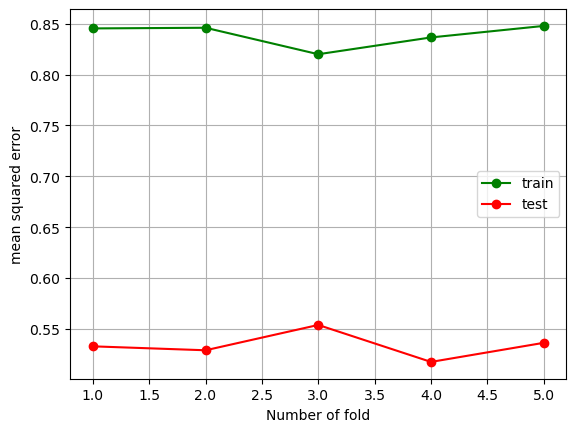

In [24]:
print("mean train performance: {}".format(performance_train.mean()))
print("mean test performance: {}".format(performance_test.mean()))

folds = range(1, kf.get_n_splits() + 1)
plt.plot(folds, performance_train, 'o-', color='green', label='train')
plt.plot(folds, performance_test, 'o-', color='red', label='test')
plt.legend()
plt.grid()
plt.xlabel('Number of fold')
plt.ylabel('mean squared error')
plt.show()

In [25]:
# final performance evaluation of best model

best_model.fit(X_train_transformed, y_train_transformed)

X_test_transformed = preprocess_pipeline.transform(X_test)
preds_y_test = best_model.predict(X_test_transformed)

# yprobs2d = best_model.predict_proba(Xtest)
# model_eval_bin(f'{model_name}+{hpo_name}', ytest, ypreds, yprobs2d, show_plots=False)

preds_y_test_inverse = label_ecoder.inverse_transform(preds_y_test)

print(classification_report(y_test, preds_y_test_inverse))

                                precision    recall  f1-score   support

B01 - Blister and sealed blist       0.74      0.70      0.71      1582
   B02 Blister and Insert Card       0.72      0.80      0.76      1749
          C01 - Folding carton       0.72      0.69      0.70      1644
                 C02 Trap Card       0.90      0.69      0.78       161
         C03 Trap Folding Card       0.80      0.56      0.66       438
            C04 Book packaging       0.25      0.50      0.33         2
               C05 Tray Packer       0.59      0.15      0.24        86
                  C06 Skincard       0.74      0.80      0.77       229
C07 Cardb. Sleeve w - w/o Shr.       0.43      0.70      0.53       135
C08 - Cardboard hanger w/o bag       0.85      0.42      0.57        80
        C09 - Paperboard pouch       0.65      0.86      0.74       696
  C10 - Carton cover (Lid box)       0.45      0.42      0.44       130
 C11 - Carton tube with or w/o       0.60      0.33      0.43  

### Deeper analysis of DecisionTreeClassifier

In [26]:
# Create df with y_test, preds_y_test & proba_preds_y_test 

# prediction
preds_y_test = best_model.predict(X_test_transformed)
preds_y_test_inverse = label_ecoder.inverse_transform(preds_y_test)

# get proba of predicted class (determine max proba value from all classes per row)
preds_y_test = best_model.predict_proba(X_test_transformed)
df_proba = pd.DataFrame(preds_y_test, columns=best_model.classes_)
df_proba['predicted_class_proba'] = df_proba.max(axis=1)
proba_preds_y_test = df_proba['predicted_class_proba'].values

y_test_dict = {
    'y_test': y_test.to_numpy(),
    'preds_y_test': preds_y_test_inverse,
    'proba_preds_y_test': proba_preds_y_test,
}

df_y_test = pd.DataFrame(y_test_dict)
df_y_test.head(30)

,y_test,preds_y_test,proba_preds_y_test
0,C01 - Folding carton,C01 - Folding carton,0.951152
1,C12 - Corrugated carton,C12 - Corrugated carton,0.942655
2,P08 Plastic Cassette,P07 Plastic Box,1.000000
3,B02 Blister and Insert Card,B02 Blister and Insert Card,1.000000
4,P08 Plastic Cassette,P08 Plastic Cassette,1.000000
5,C12 - Corrugated carton,C01 - Folding carton,1.000000
6,B01 - Blister and sealed blist,C12 - Corrugated carton,0.400733
7,P04 Hanger/ Clip,P04 Hanger/ Clip,1.000000
8,B01 - Blister and sealed blist,P06 – TightPack,1.000000
9,B01 - Blister and sealed blist,C01 - Folding carton,1.000000


In [27]:
df_y_test.loc[
    df_y_test.y_test == 'H1 Wooden box'
].head(30)

,y_test,preds_y_test,proba_preds_y_test
777,H1 Wooden box,P05 Plastic Pouch,1.0
2610,H1 Wooden box,H1 Wooden box,1.0
10792,H1 Wooden box,B02 Blister and Insert Card,1.0


In [28]:
# Create the confusion matrix
# confusion_matrix(y_test, y_pred)

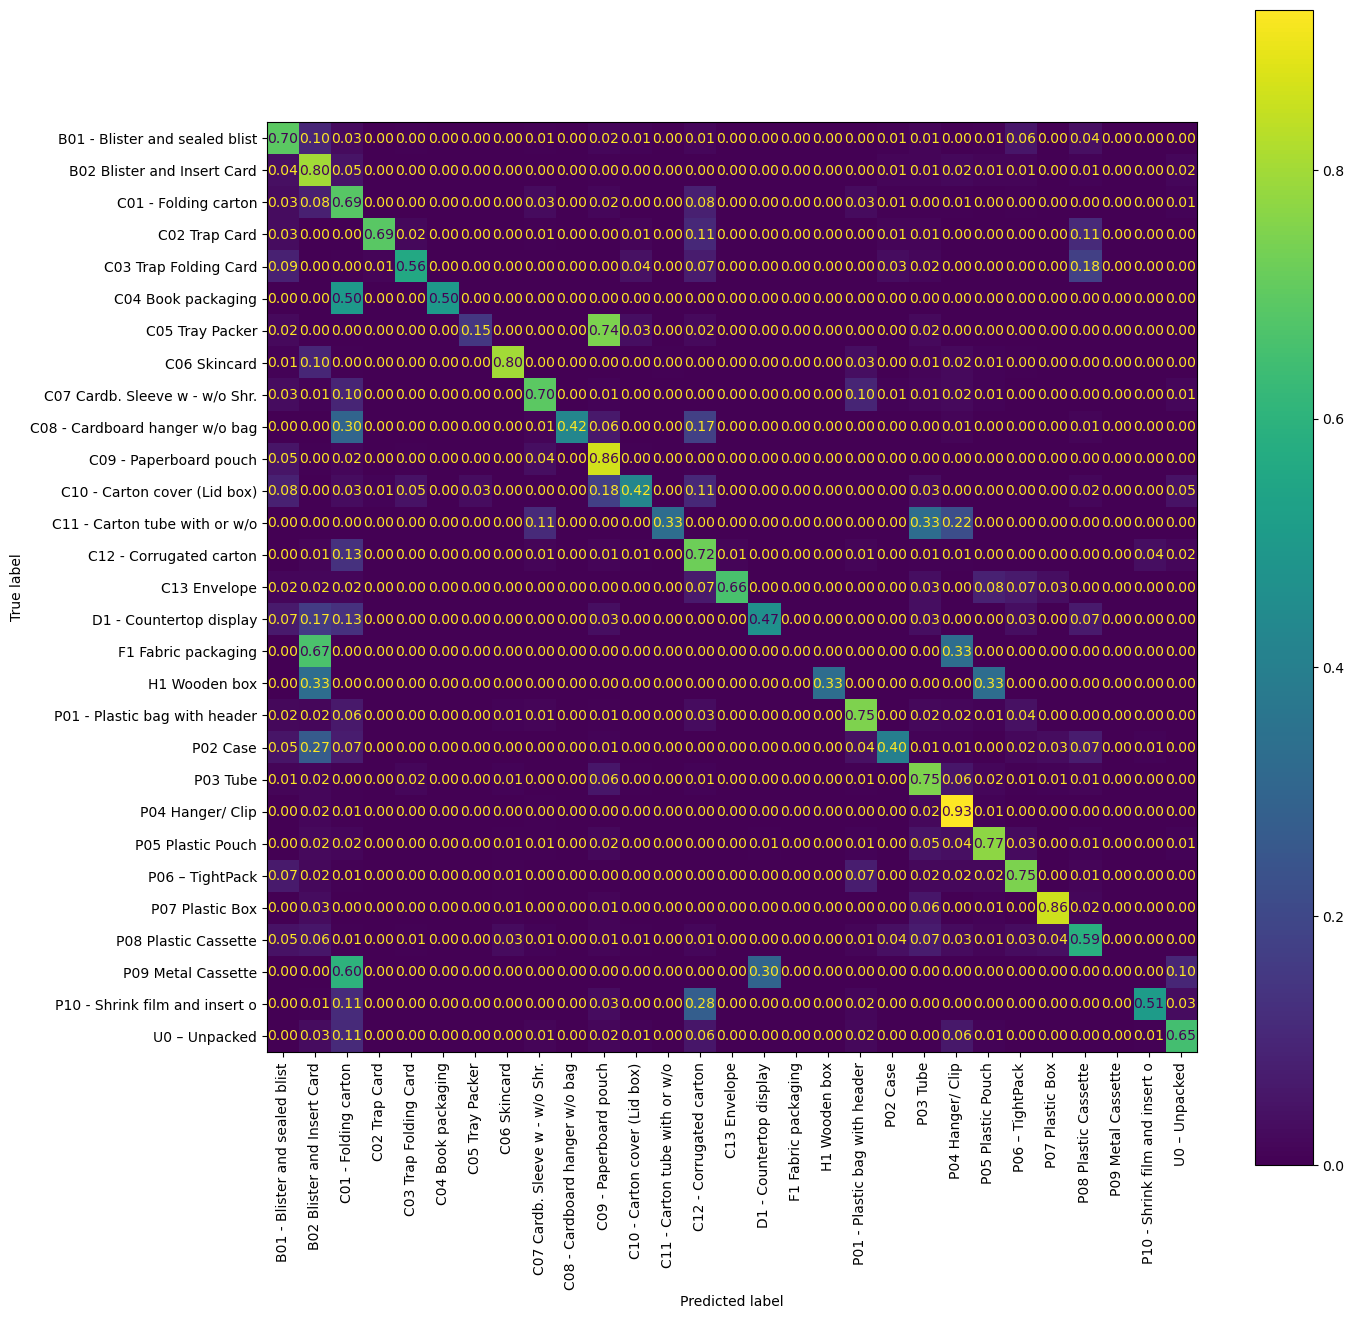

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=preds_y_test_inverse,
    normalize='true',
    values_format='.2f',
    ax=ax,
    xticks_rotation='vertical'
)

Text(0, 0.5, 'Mean decrease in impurity')

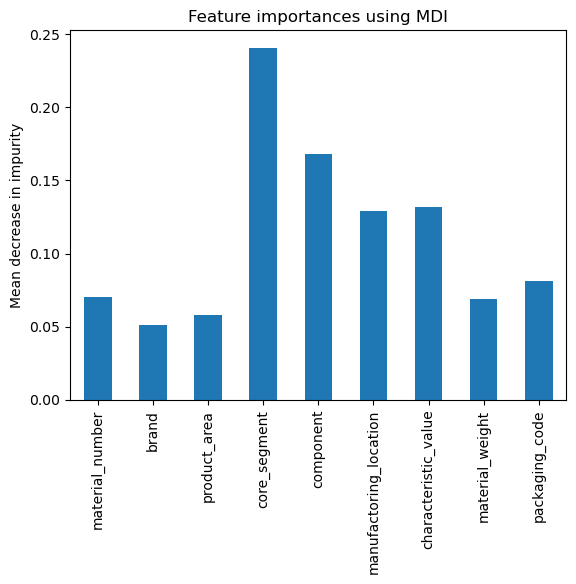

In [30]:
importances = best_model.feature_importances_
rf_importances = pd.Series(importances, index=X_train.columns.to_list())

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

# DecisionTree pipeline with oversampling

<Figure size 1000x500 with 0 Axes>

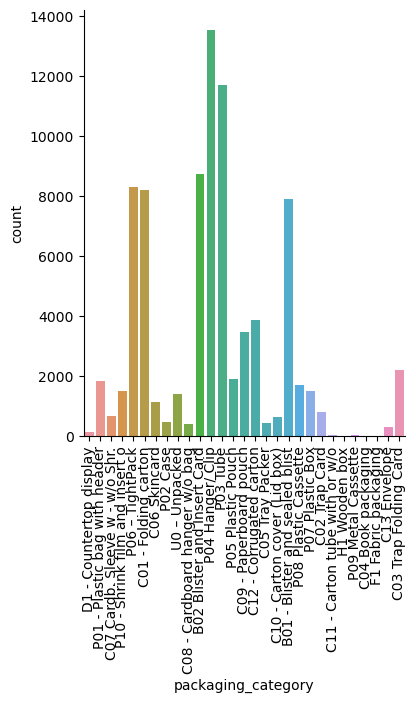

In [31]:
plt.figure(figsize=(10,5))
cat_chart = sns.catplot(
    data=df_sub,
    x='packaging_category',
    kind='count',
)
cat_chart.set_xticklabels(rotation=90)

In [32]:
distribution_classes = y.value_counts()
print('Class distribution before oversmapling')
print(distribution_classes.to_dict())

# NOTE: Oversampling so each class has at least 100 sample; to properly apply CV and evaluation
dict_oversmapling = {
    'P09 Metal Cassette': 100,
    'C11 - Carton tube with or w/o': 100,
    'H1 Wooden box': 100,
    'F1 Fabric packaging': 100,
    'C04 Book packaging': 100
}
# define oversampling strategy
oversampler = RandomOverSampler(sampling_strategy=dict_oversmapling, random_state=SEED)
# fit and apply the transform
X, y = oversampler.fit_resample(X, y)

distribution_classes = y.value_counts()
print('\n')
print('Class distribution after oversmapling')
print(distribution_classes.to_dict())

Class distribution before oversmapling
{'P04 Hanger/ Clip': 13543, 'P03 Tube': 11687, 'B02 Blister and Insert Card': 8744, 'P06 – TightPack': 8296, 'C01 - Folding carton': 8219, 'B01 - Blister and sealed blist': 7912, 'C12 - Corrugated carton': 3872, 'C09 - Paperboard pouch': 3478, 'C03 Trap Folding Card': 2188, 'P05 Plastic Pouch': 1904, 'P01 - Plastic bag with header': 1850, 'P08 Plastic Cassette': 1708, 'P10 - Shrink film and insert o': 1499, 'P07 Plastic Box': 1491, 'U0 – Unpacked': 1415, 'C06 Skincard': 1143, 'C02 Trap Card': 804, 'C07 Cardb. Sleeve w - w/o Shr.': 676, 'C10 - Carton cover (Lid box)': 652, 'P02 Case': 485, 'C05 Tray Packer': 431, 'C08 - Cardboard hanger w/o bag': 400, 'C13 Envelope': 295, 'D1 - Countertop display': 150, 'P09 Metal Cassette': 50, 'C11 - Carton tube with or w/o': 44, 'H1 Wooden box': 16, 'F1 Fabric packaging': 15, 'C04 Book packaging': 10}


Class distribution after oversmapling
{'P04 Hanger/ Clip': 13543, 'P03 Tube': 11687, 'B02 Blister and Insert C

In [33]:
# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y,
    # random_state=SEED
)

## DecisionTree (without HPO)

In [34]:
# DEFINE PIPELINE

# DEFINE PREPROCESSING PIPELINE
# define numerical feature processing
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
# print(f'There are {len(numerical_features)} numerical features:', '\n')
# print(numerical_features)
numeric_feature_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('log_transform', PowerTransformer()),
    # ('scale', MinMaxScaler())
])
# define categorical feature processing
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()
# print(f'There are {len(categorical_features)} categorical features:', '\n')
# print(categorical_features)
categorical_feature_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    # ('one_hot', OneHotEncoder(handle_unknown='ignore', max_categories=None, sparse=False))
])
# apply both pipeline on seperate columns using "ColumnTransformer"
preprocess_pipeline = ColumnTransformer(transformers=[
    ('number', numeric_feature_pipeline, numerical_features),
    ('category', categorical_feature_pipeline, categorical_features)
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

# DEFINE MODEL PIPELINE

label_ecoder = LabelEncoder()
y_train_transformed = label_ecoder.fit_transform(y_train)
# y_train_transformed = label_ecoder.fit_transform(y_train)

# class_weights
# class_weights = compute_sample_weight(
#     class_weight='balanced',
#     y=y_train_transformed
# )
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_transformed),
    y=y_train_transformed
)
class_weight_dict = dict(enumerate(class_weights))

# DEFINE MODEL PIPELINE
# model
dt_clf = DecisionTreeClassifier(
    # n_estimators=10,
    class_weight=class_weight_dict,
    # random_state=SEED
)

# Training
dt_clf.fit(X_train_transformed, y_train_transformed)

DecisionTreeClassifier(class_weight={0: 0.36320204826496705,
                                     1: 0.3286731902097557,
                                     2: 0.349668283728858,
                                     3: 3.5755349385960207,
                                     4: 1.3137536945812809,
                                     5: 28.738362068965518,
                                     6: 6.663968015992004,
                                     7: 2.5153927412661283,
                                     8: 4.249665370641851,
                                     9: 7.1845905172413795,
                                     10: 0.8264086863829049,
                                     11: 4.404346677236094,
                                     12: 28.738362068965518,
                                     13: 0.7421139333496583,
                                     14: 9.741817650496786,
                                     15: 19.15890804597701,
                                     16: 28.738362068965518,
                                     17: 28.738362068965518,
                                     18: 1.5534249767008388,
                                     19: 5.92543547813722,
                                     20: 0.24588972893232527,
                                     21: 0.2122086916667197,
                                     22: 1.5095659655398828,
                                     23: 0.34640183298436666,
                                     24: 1.9271324103245946,
                                     25: 1.6830665926187711,
                                     26: 28.738362068965518,
                                     27: 1.9174887118575825,
                                     28: 2.0309796515169976})

In [35]:
# preprocess & make predictions for test data
X_test_transformed = preprocess_pipeline.transform(X_test)
preds_y_test_dt = dt_clf.predict(X_test_transformed)

y_test_transformed = label_ecoder.transform(y_test)
preds_y_test_dt_inverse = label_ecoder.inverse_transform(preds_y_test_dt)

# score the pipeline
print("Train score (f1-score): ", dt_clf.score(X_train_transformed, y_train_transformed))
print("Test score (f1-score): ", dt_clf.score(X_test_transformed, y_test_transformed))
print(classification_report(y_test, preds_y_test_dt_inverse))

Train score (f1-score):  1.0
Test score (f1-score):  0.740896274521567
                                precision    recall  f1-score   support

B01 - Blister and sealed blist       0.71      0.69      0.70      1582
   B02 Blister and Insert Card       0.66      0.71      0.68      1749
          C01 - Folding carton       0.70      0.62      0.66      1644
                 C02 Trap Card       0.72      0.67      0.69       161
         C03 Trap Folding Card       0.78      0.74      0.76       438
            C04 Book packaging       0.95      1.00      0.98        20
               C05 Tray Packer       0.57      0.79      0.66        86
                  C06 Skincard       0.81      0.78      0.79       229
C07 Cardb. Sleeve w - w/o Shr.       0.51      0.56      0.54       135
C08 - Cardboard hanger w/o bag       0.40      0.45      0.42        80
        C09 - Paperboard pouch       0.71      0.77      0.74       696
  C10 - Carton cover (Lid box)       0.55      0.47      0.51   

## DecisionTree HPO

### Performe HPO

In [36]:
class OptunaObjective(object):

    def __init__(self, scoring, X: np.array, y: np.array):
        self.scoring=scoring
        self.X=X
        self.y=y

    def __call__(self, trial: optuna.Trial) -> float:
        
        # joblib.dump(study, 'study.pkl')

        hp_rf_optuna = {
            'max_depth': trial.suggest_categorical('max_depth', [2, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 50, 60, 80, 100]), # Maximum number of levels in tree
            # 'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt','log2']), # Number of features to consider at every split
            # 'min_samples_split': trial.suggest_int('min_samples_split', 2, 14), # Minimum number of samples required to split a node
            # 'min_samples_leaf': trial.suggest_int('min_samples_split', 1, 8), # Minimum number of samples required at each leaf node
            'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']), # function to measure the quality of a split
        }

        # Generate train/val sets randomly for each trial to prevent overfitting
        X_train, X_val, y_train, y_val = train_test_split(
            self.X, self.y, test_size=0.2, stratify=self.y, random_state=None
        )

        # class_weights
        class_weights = compute_sample_weight(
            class_weight='balanced',
            y=y_train
        )
        class_weight_dict = dict(enumerate(class_weights))

        # model
        model = DecisionTreeClassifier(
            # n_estimators=1000,
            class_weight=class_weight_dict,
            **hp_rf_optuna,
            # random_state=SEED
        )

        # fit model
        # NOTE: cross_val within an HPO study is not suggested since it is an extra layer of computational complexity;
        #       often this is not needed OR it is anyways somehow covered by the optimization strategy, e.g. Bayesian
        model.fit(X_train, y_train)
        
        # eval performance
        preds_y_val = model.predict(X_val)
        clf_report = classification_report(y_val, preds_y_val, output_dict=True)

        return clf_report['macro avg']['f1-score']

In [37]:
# define hyper-parameter space, model + training, optimization metric via Objective
objective = OptunaObjective(
    scoring="f1_macro",
    X=X_train_transformed,
    y=y_train_transformed,
)

# define and run study for optimization
# define search strategy: RandomSampler
# study = optuna.create_study(direction="maximize", sampler=optuna.RandomSampler(seed=SEED))
# define search strategy: TPESampler = bayesian optimizer with a tree-structured Parzen Estimator
study = optuna.create_study(
    study_name="rf_optuna",
    # storage=optuna_storage,
    # load_if_exists=True,
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED)
)

# define duration of the optimization process by and/or number_of_trails and timeout
study.optimize(
    objective,
    n_trials=30,
    # timeout=600, 
    show_progress_bar=True
)

[I 2023-07-12 17:06:19,076] A new study created in memory with name: rf_optuna


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-07-12 17:06:19,465] Trial 0 finished with value: 0.7404815557594326 and parameters: {'max_depth': 50, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7404815557594326.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



[I 2023-07-12 17:06:19,842] Trial 1 finished with value: 0.7559395851602633 and parameters: {'max_depth': 32, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7559395851602633.
[I 2023-07-12 17:06:19,967] Trial 2 finished with value: 0.04292194139608494 and parameters: {'max_depth': 2, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7559395851602633.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.

[I 2023-07-12 17:06:20,141] Trial 3 finished with value: 0.07533956558694399 and parameters: {'max_depth': 4, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7559395851602633.
[I 2023-07-12 17:06:20,318] Trial 4 finished with value: 0.14162620511409899 and parameters: {'max_depth': 4, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7559395851602633.
[I 2023-07-12 17:06:20,652] Trial 5 finished with value: 0.5762520670756575 and parameters: {'max_depth': 12, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7559395851602633.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



[I 2023-07-12 17:06:21,024] Trial 6 finished with value: 0.7519528036061651 and parameters: {'max_depth': 40, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7559395851602633.
[I 2023-07-12 17:06:21,188] Trial 7 finished with value: 0.32296327337740177 and parameters: {'max_depth': 8, 'criterion': 'gini'}. Best is trial 1 with value: 0.7559395851602633.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.

[I 2023-07-12 17:06:21,389] Trial 8 finished with value: 0.5370911981539398 and parameters: {'max_depth': 12, 'criterion': 'gini'}. Best is trial 1 with value: 0.7559395851602633.
[I 2023-07-12 17:06:21,562] Trial 9 finished with value: 0.12829814863686523 and parameters: {'max_depth': 4, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7559395851602633.
[I 2023-07-12 17:06:21,826] Trial 10 finished with value: 0.738033768512417 and parameters: {'max_depth': 32, 'criterion': 'gini'}. Best is trial 1 with value: 0.7559395851602633.
[I 2023-07-12 17:06:22,193] Trial 11 finished with value: 0.7314465435311583 and parameters: {'max_depth': 40, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7559395851602633.
[I 2023-07-12 17:06:22,560] Trial 12 finished with value: 0.7527200967501853 and parameters: {'max_depth': 40, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7559395851602633.
[I 2023-07-12 17:06:22,938] Trial 13 finished with value: 0.7384310771162101 and paramete

In [38]:
# print optimization results
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial
print("  Performance: ", best_trial.value)
print('  Best trial:', best_trial.params)
# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

Number of finished trials:  30
Best trial:
  Performance:  0.7594585179818435
  Best trial: {'max_depth': 60, 'criterion': 'entropy'}


### Analyse HPO
Auswertung Optuna study

In [39]:
# history of all trials
hist = study.trials_dataframe()
hist.head()

,number,value,datetime_start,datetime_complete,duration,params_criterion,params_max_depth,state
0,0,0.740482,2023-07-12 17:06:19.084424,2023-07-12 17:06:19.464957,0 days 00:00:00.380533,entropy,50,COMPLETE
1,1,0.755940,2023-07-12 17:06:19.466153,2023-07-12 17:06:19.842604,0 days 00:00:00.376451,entropy,32,COMPLETE
2,2,0.042922,2023-07-12 17:06:19.844107,2023-07-12 17:06:19.967747,0 days 00:00:00.123640,entropy,2,COMPLETE
3,3,0.075340,2023-07-12 17:06:19.968909,2023-07-12 17:06:20.141321,0 days 00:00:00.172412,entropy,4,COMPLETE
4,4,0.141626,2023-07-12 17:06:20.142659,2023-07-12 17:06:20.318032,0 days 00:00:00.175373,entropy,4,COMPLETE


In [40]:
# plot performance of all trials
optuna.visualization.plot_optimization_history(study)

In [41]:
# plot the parameter relationship concerning performance
optuna.visualization.plot_slice(study)

In [42]:
# plots the interactive visualization of the high-dimensional parameter relationship
optuna.visualization.plot_parallel_coordinate(study)

In [43]:
# plots parameter interactive chart from we can choose which hyperparameter space has to explore
optuna.visualization.plot_contour(study)

### Evaluate best model

In [44]:
best_trial.params

{'max_depth': 60, 'criterion': 'entropy'}

In [45]:
# Define best model

# best_params = best_trial.params
best_params = {
    'max_depth': 50,
    'criterion': 'entropy'
}

# class_weights
class_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train_transformed
)
class_weight_dict = dict(enumerate(class_weights))

# model
best_model = DecisionTreeClassifier(
    # n_estimators=1000,
    class_weight=class_weight_dict,
    **best_params,
    # random_state=SEED
)

In [46]:
# analyse overfitting and underfitting of best model using cross validation
from sklearn.model_selection import KFold, StratifiedKFold

def check_model_learning_CV(
    n_splits: int,
    model,
    X: pd.DataFrame,
    y: pd.DataFrame,
    preprocess_pipeline: sklearn.pipeline.Pipeline,
    label_ecoder: sklearn.preprocessing.LabelEncoder,
    random_state: int = None
):
    '''analyse overfitting and underfitting of best model using cross validation
    NOTE: moved inside a function, since transformations and training should not be puplic available
    NOTE: ignore warnings of ill-defined F-score, KFold splits might cause labels in y_true might not appear in y_pred
    '''

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    report_train = []
    report_test = []
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # preprocess given split
        X_train_tranformed = preprocess_pipeline.fit_transform(X_train)
        X_test_transformed = preprocess_pipeline.transform(X_test)
        y_train_transfomed = label_ecoder.fit_transform(y_train)
        y_test_transformed = label_ecoder.transform(y_test)

        # class_weights TODO: to be deleted since it is passed with the model itself
        # class_weights = compute_sample_weight(
        #     class_weight='balanced',
        #     y=y_train_transfomed
        # )
        # train model within given split
        model.fit(X_train_tranformed, y_train_transfomed)

        y_train_pred = model.predict(X_train_tranformed)
        y_test_pred = model.predict(X_test_transformed)

        # get performance results for given split
        report_train.append(classification_report(y_train_transfomed, y_train_pred, output_dict=True)['macro avg']['f1-score'])
        report_test.append(classification_report(y_test_transformed, y_test_pred, output_dict=True)['macro avg']['f1-score'])

    performance_train = np.array(report_train)
    performance_test = np.array(report_test)

    return performance_train, performance_test, kf


performance_train, performance_test, kf = check_model_learning_CV(
    n_splits=5,
    model=best_model,
    X=X,
    y=y,
    preprocess_pipeline=preprocess_pipeline,
    label_ecoder=label_ecoder,
    # random_state=SEED
)

mean train performance: 0.9999549731090921
mean test performance: 0.6947607543850989


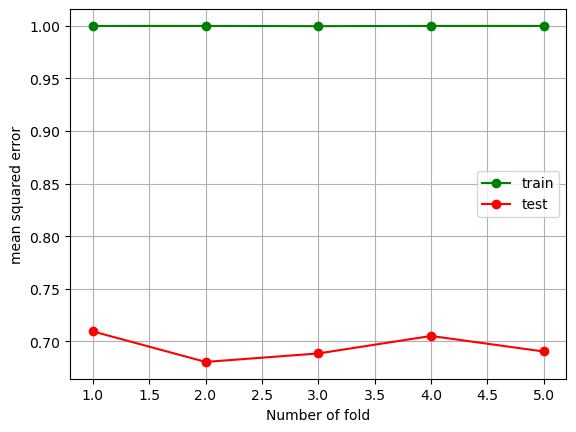

In [47]:
print("mean train performance: {}".format(performance_train.mean()))
print("mean test performance: {}".format(performance_test.mean()))

folds = range(1, kf.get_n_splits() + 1)
plt.plot(folds, performance_train, 'o-', color='green', label='train')
plt.plot(folds, performance_test, 'o-', color='red', label='test')
plt.legend()
plt.grid()
plt.xlabel('Number of fold')
plt.ylabel('mean squared error')
plt.show()

In [48]:
# final performance evaluation of best model

best_model.fit(X_train_transformed, y_train_transformed)

X_test_transformed = preprocess_pipeline.transform(X_test)
preds_y_test = best_model.predict(X_test_transformed)

# yprobs2d = best_model.predict_proba(Xtest)
# model_eval_bin(f'{model_name}+{hpo_name}', ytest, ypreds, yprobs2d, show_plots=False)

preds_y_test_inverse = label_ecoder.inverse_transform(preds_y_test)

print(classification_report(y_test, preds_y_test_inverse))

                                precision    recall  f1-score   support

B01 - Blister and sealed blist       0.70      0.66      0.68      1582
   B02 Blister and Insert Card       0.68      0.72      0.70      1749
          C01 - Folding carton       0.60      0.75      0.67      1644
                 C02 Trap Card       0.55      0.70      0.62       161
         C03 Trap Folding Card       0.86      0.57      0.69       438
            C04 Book packaging       1.00      0.90      0.95        20
               C05 Tray Packer       0.50      0.15      0.23        86
                  C06 Skincard       0.84      0.84      0.84       229
C07 Cardb. Sleeve w - w/o Shr.       0.36      0.43      0.39       135
C08 - Cardboard hanger w/o bag       0.47      0.44      0.45        80
        C09 - Paperboard pouch       0.79      0.60      0.68       696
  C10 - Carton cover (Lid box)       0.41      0.26      0.32       130
 C11 - Carton tube with or w/o       0.29      0.25      0.27  

### Deeper analysis of DecisionTreeClassifier

In [49]:
# Create df with y_test, preds_y_test & proba_preds_y_test 

# prediction
preds_y_test = best_model.predict(X_test_transformed)
preds_y_test_inverse = label_ecoder.inverse_transform(preds_y_test)

# get proba of predicted class (determine max proba value from all classes per row)
preds_y_test = best_model.predict_proba(X_test_transformed)
df_proba = pd.DataFrame(preds_y_test, columns=best_model.classes_)
df_proba['predicted_class_proba'] = df_proba.max(axis=1)
proba_preds_y_test = df_proba['predicted_class_proba'].values

y_test_dict = {
    'y_test': y_test.to_numpy(),
    'preds_y_test': preds_y_test_inverse,
    'proba_preds_y_test': proba_preds_y_test,
}

df_y_test = pd.DataFrame(y_test_dict)
df_y_test.head(30)

,y_test,preds_y_test,proba_preds_y_test
0,P04 Hanger/ Clip,P04 Hanger/ Clip,1.0
1,P06 – TightPack,P06 – TightPack,1.0
2,P04 Hanger/ Clip,P04 Hanger/ Clip,1.0
3,P03 Tube,P03 Tube,1.0
4,P01 - Plastic bag with header,P06 – TightPack,1.0
5,C07 Cardb. Sleeve w - w/o Shr.,C01 - Folding carton,1.0
6,B02 Blister and Insert Card,D1 - Countertop display,1.0
7,C01 - Folding carton,C01 - Folding carton,1.0
8,B01 - Blister and sealed blist,P08 Plastic Cassette,1.0
9,P03 Tube,C09 - Paperboard pouch,1.0


In [50]:
df_y_test.loc[
    df_y_test.y_test == 'H1 Wooden box'
].head(30)

,y_test,preds_y_test,proba_preds_y_test
1889,H1 Wooden box,H1 Wooden box,1.0
2786,H1 Wooden box,P07 Plastic Box,1.0
3135,H1 Wooden box,H1 Wooden box,1.0
3187,H1 Wooden box,H1 Wooden box,1.0
3438,H1 Wooden box,H1 Wooden box,1.0
4060,H1 Wooden box,H1 Wooden box,1.0
6860,H1 Wooden box,H1 Wooden box,1.0
6963,H1 Wooden box,P07 Plastic Box,1.0
8034,H1 Wooden box,P07 Plastic Box,1.0
8296,H1 Wooden box,C13 Envelope,1.0


In [51]:
# Create the confusion matrix
# confusion_matrix(y_test, y_pred)

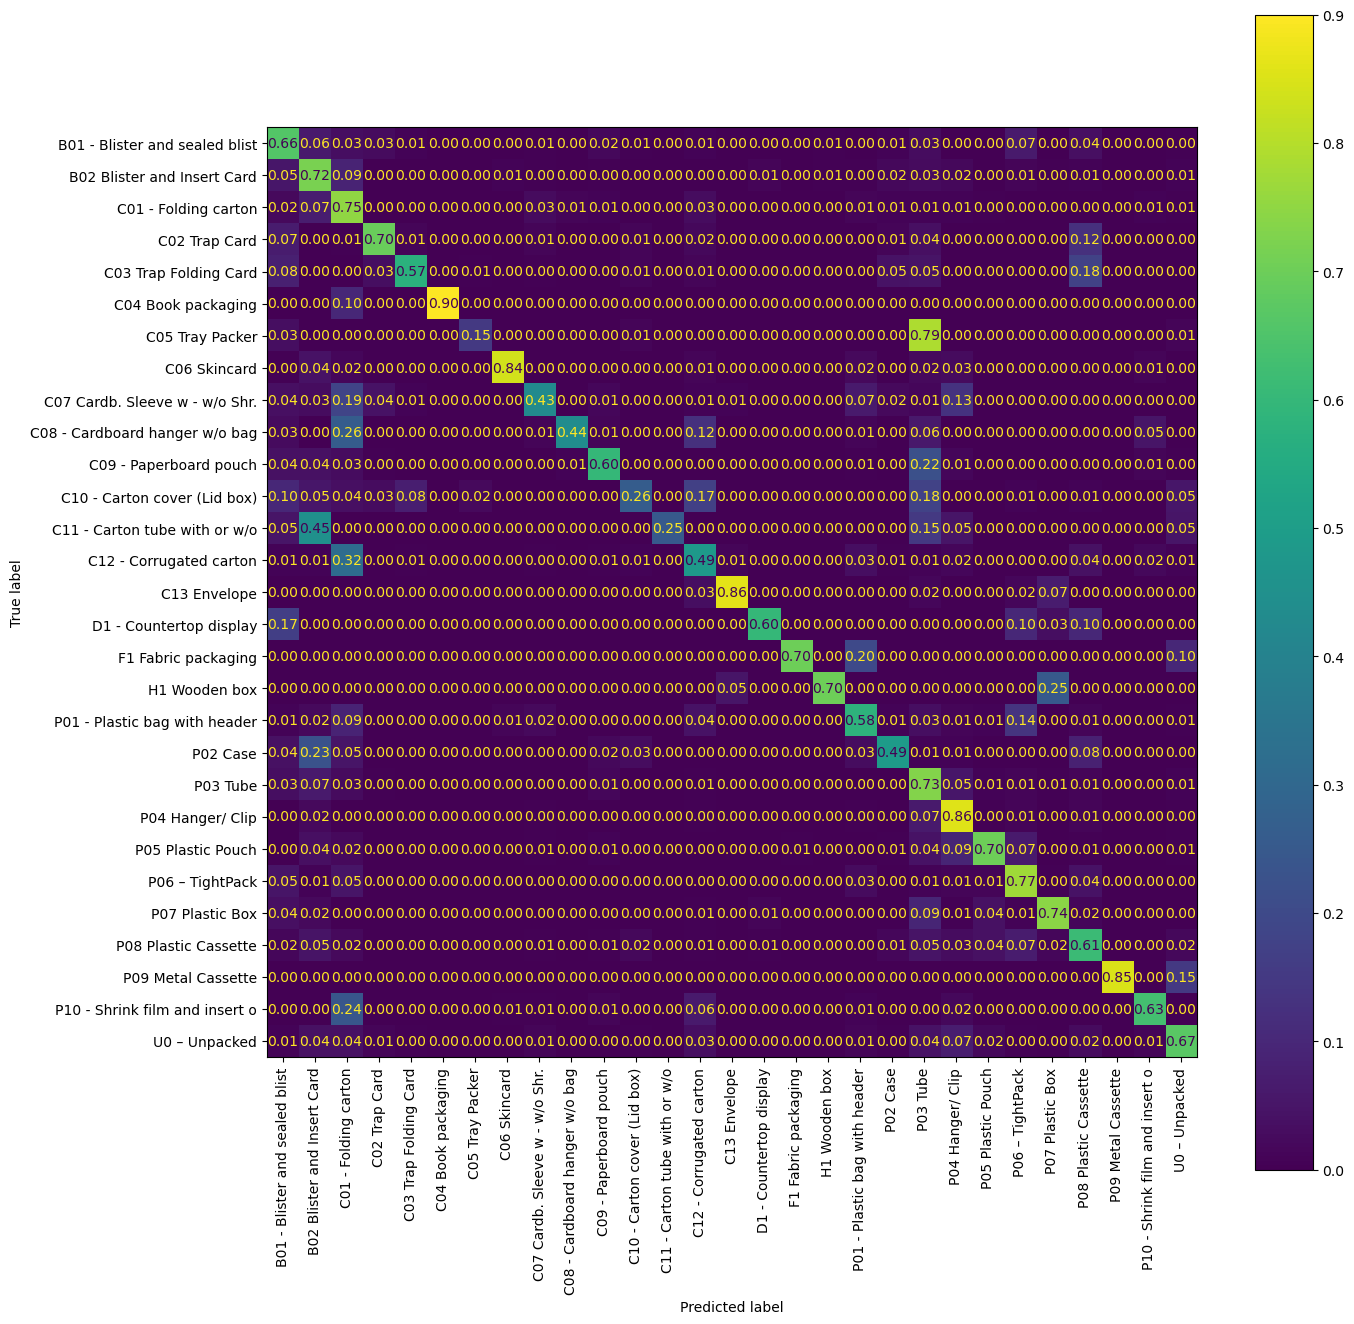

In [52]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=preds_y_test_inverse,
    normalize='true',
    values_format='.2f',
    ax=ax,
    xticks_rotation='vertical'
)

Text(0, 0.5, 'Mean decrease in impurity')

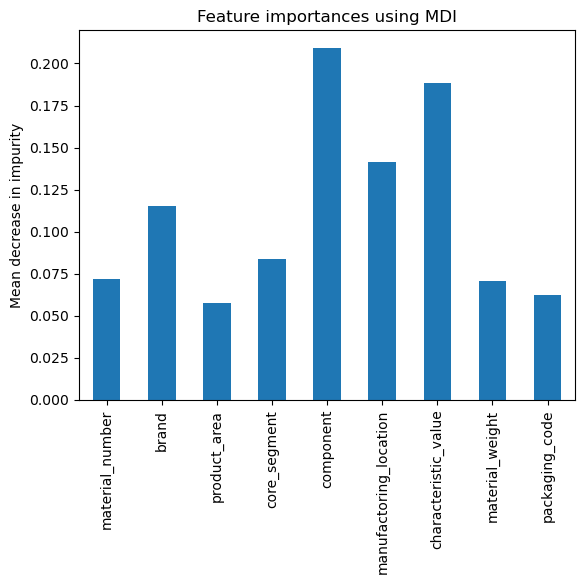

In [53]:
importances = best_model.feature_importances_
rf_importances = pd.Series(importances, index=X_train.columns.to_list())

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

# Threshold analysis best model

Findings threshold analysis: since the decision tree does not provide probabilty a threshold analysis does not make any sense

In [54]:
# Create df with y_test, preds_y_test & proba_preds_y_test 

# prediction
preds_y_test = best_model.predict(X_test_transformed)
preds_y_test_inverse = label_ecoder.inverse_transform(preds_y_test)

# get proba of predicted class (determine max proba value from all classes per row)
preds_y_test = best_model.predict_proba(X_test_transformed)
df_proba = pd.DataFrame(preds_y_test, columns=best_model.classes_)
df_proba['predicted_class_proba'] = df_proba.max(axis=1)
proba_preds_y_test = df_proba['predicted_class_proba'].values

y_test_dict = {
    'y_test': y_test.to_numpy(),
    'preds_y_test': preds_y_test_inverse,
    'proba_preds_y_test': proba_preds_y_test,
}

df_y_test = pd.DataFrame(y_test_dict)
df_y_test.head(30)

,y_test,preds_y_test,proba_preds_y_test
0,P04 Hanger/ Clip,P04 Hanger/ Clip,1.0
1,P06 – TightPack,P06 – TightPack,1.0
2,P04 Hanger/ Clip,P04 Hanger/ Clip,1.0
3,P03 Tube,P03 Tube,1.0
4,P01 - Plastic bag with header,P06 – TightPack,1.0
5,C07 Cardb. Sleeve w - w/o Shr.,C01 - Folding carton,1.0
6,B02 Blister and Insert Card,D1 - Countertop display,1.0
7,C01 - Folding carton,C01 - Folding carton,1.0
8,B01 - Blister and sealed blist,P08 Plastic Cassette,1.0
9,P03 Tube,C09 - Paperboard pouch,1.0


In [55]:
df_y_test_threshold = df_y_test.copy()
df_y_test_threshold.head()

,y_test,preds_y_test,proba_preds_y_test
0,P04 Hanger/ Clip,P04 Hanger/ Clip,1.0
1,P06 – TightPack,P06 – TightPack,1.0
2,P04 Hanger/ Clip,P04 Hanger/ Clip,1.0
3,P03 Tube,P03 Tube,1.0
4,P01 - Plastic bag with header,P06 – TightPack,1.0


In [56]:
# threshhold None

df_y_test_threshold_X = df_y_test_threshold

def custom_class_report(y_true, y_preds):
    report = classification_report(y_true, y_preds, output_dict=True)
    print(classification_report(y_true, y_preds))
    return report

rf_clf_classification_report = custom_class_report(df_y_test_threshold_X.y_test, df_y_test_threshold_X.preds_y_test)

                                precision    recall  f1-score   support

B01 - Blister and sealed blist       0.70      0.66      0.68      1582
   B02 Blister and Insert Card       0.68      0.72      0.70      1749
          C01 - Folding carton       0.60      0.75      0.67      1644
                 C02 Trap Card       0.55      0.70      0.62       161
         C03 Trap Folding Card       0.86      0.57      0.69       438
            C04 Book packaging       1.00      0.90      0.95        20
               C05 Tray Packer       0.50      0.15      0.23        86
                  C06 Skincard       0.84      0.84      0.84       229
C07 Cardb. Sleeve w - w/o Shr.       0.36      0.43      0.39       135
C08 - Cardboard hanger w/o bag       0.47      0.44      0.45        80
        C09 - Paperboard pouch       0.79      0.60      0.68       696
  C10 - Carton cover (Lid box)       0.41      0.26      0.32       130
 C11 - Carton tube with or w/o       0.29      0.25      0.27  

In [57]:
# threshhold 95
df_y_test_threshold_X = df_y_test_threshold.loc[
    df_y_test_threshold.proba_preds_y_test >= 0.95
]

def custom_class_report(y_true, y_preds):
    report = classification_report(y_true, y_preds, output_dict=True)
    print(classification_report(y_true, y_preds))
    return report

rf_clf_classification_report = custom_class_report(df_y_test_threshold_X.y_test, df_y_test_threshold_X.preds_y_test)

                                precision    recall  f1-score   support

B01 - Blister and sealed blist       0.70      0.66      0.68      1582
   B02 Blister and Insert Card       0.68      0.72      0.70      1749
          C01 - Folding carton       0.60      0.75      0.67      1644
                 C02 Trap Card       0.55      0.70      0.62       161
         C03 Trap Folding Card       0.86      0.57      0.69       438
            C04 Book packaging       1.00      0.90      0.95        20
               C05 Tray Packer       0.50      0.15      0.23        86
                  C06 Skincard       0.84      0.84      0.84       229
C07 Cardb. Sleeve w - w/o Shr.       0.36      0.43      0.39       135
C08 - Cardboard hanger w/o bag       0.47      0.44      0.45        80
        C09 - Paperboard pouch       0.79      0.60      0.68       696
  C10 - Carton cover (Lid box)       0.41      0.26      0.32       130
 C11 - Carton tube with or w/o       0.29      0.25      0.27  

In [ ]:
# load full dataset (assinged & unassinged SKUs)
df_raw = pd.read_csv('../../data/data_showcase.csv', sep='\t')

# data cleaning (data formats, general transformations, "feature selection")
df_cleaned = df_raw.rename(columns={
    'Product Area': 'product_area',
    'Core Segment': 'core_segment',
    'Brand': 'brand',
    'Material Number': 'material_number',
    'Material No Text': 'material_number_text',
    'Component': 'component',
    'Material Description': 'component_text',
    'Packaging Code': 'packaging_code',
    'Material Characteristic': 'characteristic_value',
    'Material Weight': 'material_weight',
    'Column 21': 'col_21',
    'Weight measure': 'weight_measure',
    'Packaging Category': 'packaging_category',
    'Manufactoring Location': 'manufactoring_location',
    'Column 43': 'col_43'
})

df_cleaned['packaging_category'] = df_cleaned['packaging_category'].astype('object')

df_cleaned['packaging_category'].mask(
    df_cleaned['packaging_category'].isin(['-', np.nan]), 'Unassigned', inplace=True
)

df_cleaned['packaging_category'].mask(
    df_cleaned['packaging_category'].isin(['No Packaging']), 'U0 – Unpacked', inplace=True
)

df_full_sub = df_cleaned[[
    'material_number',
    'brand',
    'product_area',
    'core_segment',
    'component',
    'manufactoring_location',
    'characteristic_value',
    'material_weight', 
    'packaging_code',
    'packaging_category',
]]

# TODO(optional): data quality checks (e.g. ensure features have the right format, size of input data, ...)


# final training data
# split data into "assigned" == X, and "unassinged" == X_prod
df_ml = df_full_sub[df_full_sub.packaging_category != 'Unassigned']
# Define features and target
X = df_ml.iloc[:, :-1]
y = df_ml.iloc[:, -1]  # the last column is the target
# NOTE: Oversampling so each class has at least 100 sample; to properly apply CV and evaluation
dict_oversmapling = {
    'P09 Metal Cassette': 100,
    'C11 - Carton tube with or w/o': 100,
    'H1 Wooden box': 100,
    'F1 Fabric packaging': 100,
    'C04 Book packaging': 100
}
# define oversampling strategy
oversampler = RandomOverSampler(sampling_strategy=dict_oversmapling, random_state=SEED)
# fit and apply the transform
X, y = oversampler.fit_resample(X, y)


# production data (for inference)
df_no_packaging_categories = df_full_sub[df_full_sub.packaging_category == 'Unassigned']
# Define features and target
X_inf = df_no_packaging_categories.iloc[:, :-1]
y_inf = df_no_packaging_categories.iloc[:, -1]  # the last column is the target